<a href="https://colab.research.google.com/github/Tieck-IT/Study/blob/main/tf_keras/%5Bwgan_gp%5Dfashion_mnnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

from https://keras.io/examples/generative/wgan_gp/

# 데이터 준비

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Input, Reshape
from tensorflow.keras.layers import LeakyReLU, Activation
from tensorflow.keras.layers import Cropping2D, ZeroPadding2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback

In [2]:
IMG_SHAPE = (28, 28, 1)
BATCH_SIZE = 512

noise_dim = 128

dataset = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = dataset.load_data()
print(f"Number of examples: {len(train_images)}")
print(f"Shape of the images in the dataset: {train_images.shape[1:]}")

train_images = train_images.reshape(train_images.shape[0], *IMG_SHAPE).astype("float32")
train_images = (train_images - 127.5) / 127.5


4431872/4422102 [==============================] - 0s 0us/step
Number of examples: 60000
Shape of the images in the dataset: (28, 28)


# D 정의

In [3]:
def conv_block(
    x,
    filters,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    activation = LeakyReLU(0.2),
    use_bias=True,
    use_bn=False,
    use_dropout=False,
    drop_value=0.3,
):
    x = Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)
    if use_bn:
        x = BatchNormalization()(x)
    x = activation(x)
    if use_dropout:
        x = Dropout(drop_value)(x)
    return x


def get_discriminator_model():
    img_input = Input(shape=IMG_SHAPE)
    # 28x28 영상을 32x32로 만드릭 위해 padding 한다.
    x = ZeroPadding2D((2, 2))(img_input)
    x = conv_block(x,  64, (5, 5), use_dropout=False)
    x = conv_block(x, 128, (5, 5), use_dropout=True)
    x = conv_block(x, 256, (5, 5), use_dropout=True)
    x = conv_block(x, 512, (5, 5), use_dropout=False)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    x = Dense(1)(x)

    d_model = keras.models.Model(img_input, x, name="discriminator")
    return d_model


d_model = get_discriminator_model()
d_model.summary()


Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 32, 32, 1)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 64)   1664        ['zero_padding2d[0][0]']         
                                                                                                  
 leaky_re_lu (LeakyReLU)        multiple             0           ['conv2d[0][0]',                 
                                                                  'conv2d_1[0][0]',   

# G 정의


In [4]:

def upsample_block(
    x,
    filters,
    kernel_size=(3, 3),
    strides=(1, 1),
    up_size=(2, 2),
    padding="same",
    activation = LeakyReLU(0.2),
    use_bn=True,
    use_bias=False,
    use_dropout=False,
    drop_value=0.3,
):
    x = UpSampling2D(up_size)(x)
    x = Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)

    if use_bn:
        x = BatchNormalization()(x)

    if activation:
        x = activation(x)
    if use_dropout:
        x = Dropout(drop_value)(x)
    return x


def get_generator_model():
    noise = Input(shape=(noise_dim,))
    x = Dense(4 * 4 * 256, use_bias=False)(noise)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = Reshape((4, 4, 256))(x)
    x = upsample_block(x, 128, )
    x = upsample_block(x,  64, )
    x = upsample_block(x,   1, activation=Activation("tanh"))
    # 생성된 이미지 32x32를 28x28로 만들기 위해 cropping한다.
    x = Cropping2D((2, 2))(x)

    g_model = keras.models.Model(noise, x, name="generator")
    return g_model


g_model = get_generator_model()
g_model.summary()


Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 4096)         524288      ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 4096)        16384       ['dense_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 leaky_re_lu_2 (LeakyReLU)      (None, 4096)         0           ['batch_normalization[0][

# WGAN-GP 모델 정의

In [5]:
class WGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=3,
        gp_weight=10.0,
    ):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images):
        # Get the interpolated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.discriminator(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        batch_size = tf.shape(real_images)[0]

        # D 학습

        # D는 G에 비해 d_steps 배 학습함.
        for i in range(self.d_steps):
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
            with tf.GradientTape() as tape:
                fake_images = self.generator(random_latent_vectors, training=True) # 가짜 이미지 생성
                fake_logits = self.discriminator(fake_images, training=True) # logit : https://haje01.github.io/2019/11/19/logit.html
                real_logits = self.discriminator(real_images, training=True)

                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                d_loss = d_cost + gp * self.gp_weight

            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(d_gradient, self.discriminator.trainable_variables))

        # G 학습
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            generated_images = self.generator(random_latent_vectors, training=True)
            gen_img_logits = self.discriminator(generated_images, training=True)
            g_loss = self.g_loss_fn(gen_img_logits)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(gen_gradient, self.generator.trainable_variables))

        return {"d_loss": d_loss, "g_loss": g_loss}

# 에폭 마다 결과 보는 callback

In [6]:
import matplotlib.pyplot as plt

class GANMonitor(Callback):
    def __init__(self, num_img=6, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        print("epoch",epoch)
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = (generated_images * 127.5) + 127.5

        plt.figure(figsize=(10, 3))
        for i in range(1, self.num_img):
            ax = plt.subplot(1, self.num_img, i)
            plt.imshow(generated_images[i-1].numpy().squeeze(), cmap="binary")
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        plt.show()

        # for i in range(self.num_img):
        #     img = generated_images[i].numpy()
        #     img = keras.preprocessing.image.array_to_img(img)
        #     img.save("generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch))



# 학습


Epoch 1/100
118/118 [==============================] - ETA: 0s - d_loss: -7.7525 - g_loss: -16.9502epoch 0


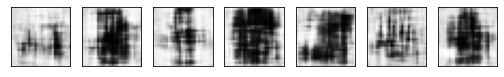

118/118 [==============================] - 87s 575ms/step - d_loss: -7.7569 - g_loss: -16.9318
Epoch 2/100
118/118 [==============================] - ETA: 0s - d_loss: -7.1463 - g_loss: -7.6871epoch 1


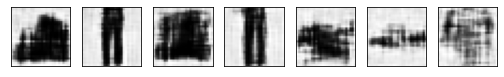

118/118 [==============================] - 68s 575ms/step - d_loss: -7.1499 - g_loss: -7.6792
Epoch 3/100
118/118 [==============================] - ETA: 0s - d_loss: -6.3303 - g_loss: -2.8797epoch 2


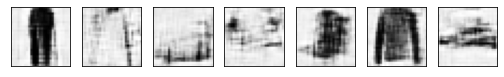

118/118 [==============================] - 68s 574ms/step - d_loss: -6.3260 - g_loss: -2.8554
Epoch 4/100
118/118 [==============================] - ETA: 0s - d_loss: -5.7272 - g_loss: -0.3683epoch 3


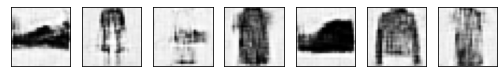

118/118 [==============================] - 68s 574ms/step - d_loss: -5.7229 - g_loss: -0.3608
Epoch 5/100
118/118 [==============================] - ETA: 0s - d_loss: -5.2920 - g_loss: 1.7515epoch 4


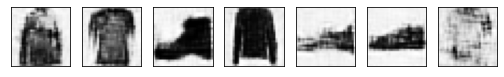

118/118 [==============================] - 68s 575ms/step - d_loss: -5.2923 - g_loss: 1.7483
Epoch 6/100
118/118 [==============================] - ETA: 0s - d_loss: -4.8962 - g_loss: 2.5819epoch 5


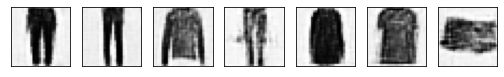

118/118 [==============================] - 68s 574ms/step - d_loss: -4.9001 - g_loss: 2.5910
Epoch 7/100
118/118 [==============================] - ETA: 0s - d_loss: -4.6150 - g_loss: 3.7392epoch 6


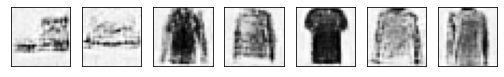

118/118 [==============================] - 68s 576ms/step - d_loss: -4.6095 - g_loss: 3.7601
Epoch 8/100
118/118 [==============================] - ETA: 0s - d_loss: -4.3113 - g_loss: 4.1648epoch 7


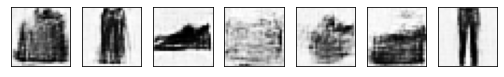

118/118 [==============================] - 68s 574ms/step - d_loss: -4.3121 - g_loss: 4.1546
Epoch 9/100
118/118 [==============================] - ETA: 0s - d_loss: -4.0604 - g_loss: 5.5415epoch 8


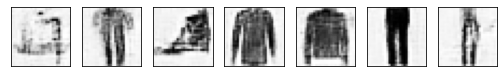

118/118 [==============================] - 68s 574ms/step - d_loss: -4.0602 - g_loss: 5.5459
Epoch 10/100
118/118 [==============================] - ETA: 0s - d_loss: -3.8420 - g_loss: 3.7152epoch 9


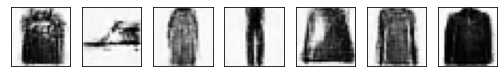

118/118 [==============================] - 68s 574ms/step - d_loss: -3.8452 - g_loss: 3.6961
Epoch 11/100
118/118 [==============================] - ETA: 0s - d_loss: -3.6526 - g_loss: 4.1812epoch 10


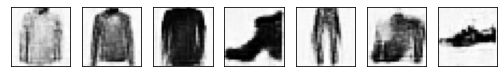

118/118 [==============================] - 68s 574ms/step - d_loss: -3.6534 - g_loss: 4.1725
Epoch 12/100
118/118 [==============================] - ETA: 0s - d_loss: -3.4573 - g_loss: 4.9651epoch 11


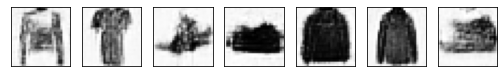

118/118 [==============================] - 68s 578ms/step - d_loss: -3.4559 - g_loss: 4.9723
Epoch 13/100
118/118 [==============================] - ETA: 0s - d_loss: -3.3114 - g_loss: 5.9154epoch 12


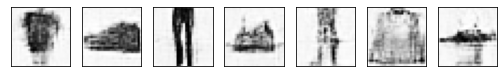

118/118 [==============================] - 68s 575ms/step - d_loss: -3.3136 - g_loss: 5.8964
Epoch 14/100
118/118 [==============================] - ETA: 0s - d_loss: -3.1284 - g_loss: 5.3554epoch 13


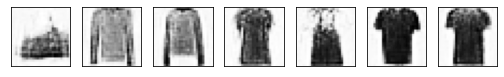

118/118 [==============================] - 68s 576ms/step - d_loss: -3.1265 - g_loss: 5.3532
Epoch 15/100
118/118 [==============================] - ETA: 0s - d_loss: -2.9971 - g_loss: 4.5715epoch 14


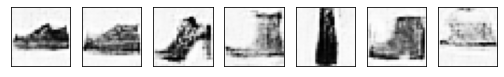

118/118 [==============================] - 68s 575ms/step - d_loss: -3.0030 - g_loss: 4.5730
Epoch 16/100
118/118 [==============================] - ETA: 0s - d_loss: -2.9550 - g_loss: 6.8053epoch 15


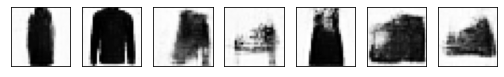

118/118 [==============================] - 68s 575ms/step - d_loss: -2.9580 - g_loss: 6.7792
Epoch 17/100
118/118 [==============================] - ETA: 0s - d_loss: -2.8750 - g_loss: 5.2648epoch 16


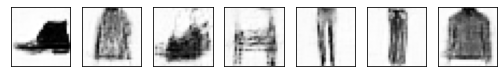

118/118 [==============================] - 68s 575ms/step - d_loss: -2.8727 - g_loss: 5.2483
Epoch 18/100
118/118 [==============================] - ETA: 0s - d_loss: -2.7762 - g_loss: 5.2048epoch 17


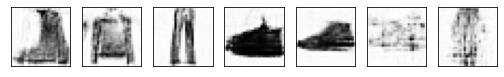

118/118 [==============================] - 68s 575ms/step - d_loss: -2.7770 - g_loss: 5.1973
Epoch 19/100
118/118 [==============================] - ETA: 0s - d_loss: -2.6934 - g_loss: 5.1707epoch 18


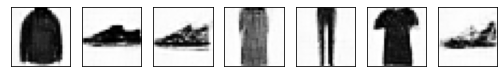

118/118 [==============================] - 68s 576ms/step - d_loss: -2.6887 - g_loss: 5.1604
Epoch 20/100
118/118 [==============================] - ETA: 0s - d_loss: -2.6999 - g_loss: 5.3512epoch 19


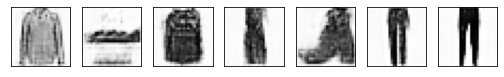

118/118 [==============================] - 68s 575ms/step - d_loss: -2.7030 - g_loss: 5.3780
Epoch 21/100
118/118 [==============================] - ETA: 0s - d_loss: -2.5184 - g_loss: 6.4279epoch 20


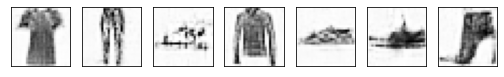

118/118 [==============================] - 68s 576ms/step - d_loss: -2.5151 - g_loss: 6.4120
Epoch 22/100
118/118 [==============================] - ETA: 0s - d_loss: -2.5288 - g_loss: 7.3586epoch 21


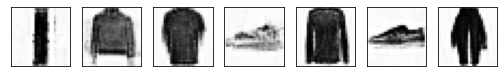

118/118 [==============================] - 68s 577ms/step - d_loss: -2.5408 - g_loss: 7.3637
Epoch 23/100
118/118 [==============================] - ETA: 0s - d_loss: -2.4952 - g_loss: 6.5843epoch 22


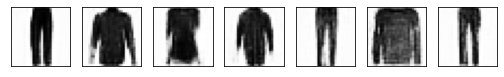

118/118 [==============================] - 68s 575ms/step - d_loss: -2.5056 - g_loss: 6.5714
Epoch 24/100
118/118 [==============================] - ETA: 0s - d_loss: -2.4406 - g_loss: 6.3925epoch 23


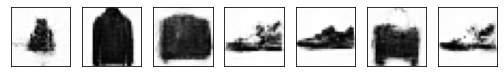

118/118 [==============================] - 68s 575ms/step - d_loss: -2.4621 - g_loss: 6.3649
Epoch 25/100
118/118 [==============================] - ETA: 0s - d_loss: -2.3646 - g_loss: 6.3759epoch 24


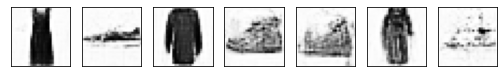

118/118 [==============================] - 68s 576ms/step - d_loss: -2.3668 - g_loss: 6.3734
Epoch 26/100
118/118 [==============================] - ETA: 0s - d_loss: -2.3083 - g_loss: 5.8968epoch 25


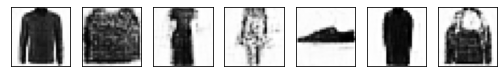

118/118 [==============================] - 68s 575ms/step - d_loss: -2.3026 - g_loss: 5.9125
Epoch 27/100
118/118 [==============================] - ETA: 0s - d_loss: -2.3344 - g_loss: 6.6237epoch 26


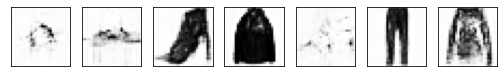

118/118 [==============================] - 68s 576ms/step - d_loss: -2.3357 - g_loss: 6.6037
Epoch 28/100
118/118 [==============================] - ETA: 0s - d_loss: -2.2374 - g_loss: 7.5464epoch 27


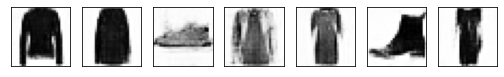

118/118 [==============================] - 68s 575ms/step - d_loss: -2.2486 - g_loss: 7.5183
Epoch 29/100
118/118 [==============================] - ETA: 0s - d_loss: -2.2334 - g_loss: 8.5273epoch 28


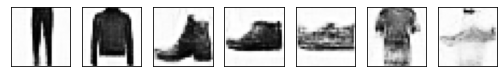

118/118 [==============================] - 68s 578ms/step - d_loss: -2.2341 - g_loss: 8.5234
Epoch 30/100
118/118 [==============================] - ETA: 0s - d_loss: -2.1863 - g_loss: 7.8548epoch 29


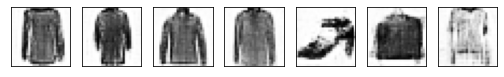

118/118 [==============================] - 68s 580ms/step - d_loss: -2.1968 - g_loss: 7.8842
Epoch 31/100
118/118 [==============================] - ETA: 0s - d_loss: -2.1558 - g_loss: 7.7555epoch 30


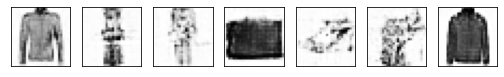

118/118 [==============================] - 68s 577ms/step - d_loss: -2.1490 - g_loss: 7.7509
Epoch 32/100
118/118 [==============================] - ETA: 0s - d_loss: -2.1259 - g_loss: 6.9478epoch 31


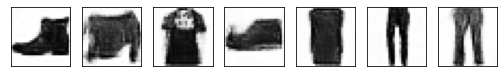

118/118 [==============================] - 68s 577ms/step - d_loss: -2.1244 - g_loss: 6.9329
Epoch 33/100
118/118 [==============================] - ETA: 0s - d_loss: -2.0586 - g_loss: 6.8954epoch 32


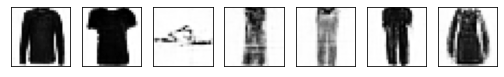

118/118 [==============================] - 68s 577ms/step - d_loss: -2.0473 - g_loss: 6.8729
Epoch 34/100
118/118 [==============================] - ETA: 0s - d_loss: -2.1062 - g_loss: 6.1312epoch 33


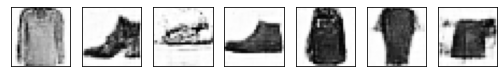

118/118 [==============================] - 68s 576ms/step - d_loss: -2.0989 - g_loss: 6.1338
Epoch 35/100
118/118 [==============================] - ETA: 0s - d_loss: -1.9880 - g_loss: 5.5956epoch 34


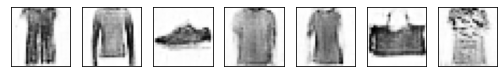

118/118 [==============================] - 68s 576ms/step - d_loss: -1.9880 - g_loss: 5.5974
Epoch 36/100
118/118 [==============================] - ETA: 0s - d_loss: -2.0272 - g_loss: 6.0684epoch 35


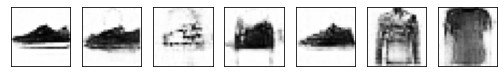

118/118 [==============================] - 68s 577ms/step - d_loss: -2.0222 - g_loss: 6.0672
Epoch 37/100
118/118 [==============================] - ETA: 0s - d_loss: -1.9909 - g_loss: 6.5294epoch 36


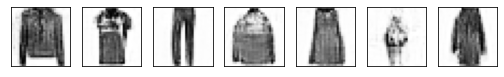

118/118 [==============================] - 68s 578ms/step - d_loss: -1.9791 - g_loss: 6.5056
Epoch 38/100
118/118 [==============================] - ETA: 0s - d_loss: -1.9732 - g_loss: 5.1985epoch 37


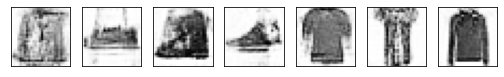

118/118 [==============================] - 68s 576ms/step - d_loss: -1.9769 - g_loss: 5.1834
Epoch 39/100
118/118 [==============================] - ETA: 0s - d_loss: -2.0231 - g_loss: 6.3641epoch 38


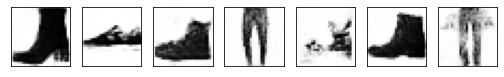

118/118 [==============================] - 68s 576ms/step - d_loss: -2.0176 - g_loss: 6.3298
Epoch 40/100
118/118 [==============================] - ETA: 0s - d_loss: -1.9341 - g_loss: 6.0151epoch 39


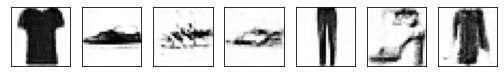

118/118 [==============================] - 68s 577ms/step - d_loss: -1.9479 - g_loss: 6.0309
Epoch 41/100
118/118 [==============================] - ETA: 0s - d_loss: -1.9957 - g_loss: 7.0350epoch 40


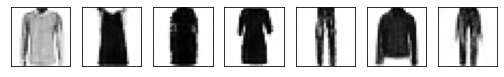

118/118 [==============================] - 68s 577ms/step - d_loss: -2.0002 - g_loss: 7.0064
Epoch 42/100
118/118 [==============================] - ETA: 0s - d_loss: -1.9137 - g_loss: 6.4693epoch 41


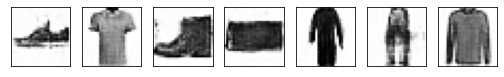

118/118 [==============================] - 68s 577ms/step - d_loss: -1.9171 - g_loss: 6.4703
Epoch 43/100
118/118 [==============================] - ETA: 0s - d_loss: -1.9145 - g_loss: 5.9018epoch 42


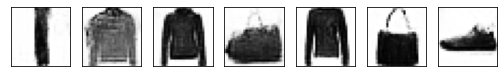

118/118 [==============================] - 68s 577ms/step - d_loss: -1.9127 - g_loss: 5.8847
Epoch 44/100
118/118 [==============================] - ETA: 0s - d_loss: -1.9887 - g_loss: 7.2835epoch 43


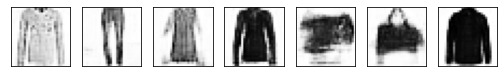

118/118 [==============================] - 68s 578ms/step - d_loss: -1.9895 - g_loss: 7.2559
Epoch 45/100
118/118 [==============================] - ETA: 0s - d_loss: -1.8691 - g_loss: 4.3529epoch 44


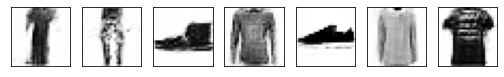

118/118 [==============================] - 68s 577ms/step - d_loss: -1.8913 - g_loss: 4.3479
Epoch 46/100
118/118 [==============================] - ETA: 0s - d_loss: -1.8778 - g_loss: 5.0862epoch 45


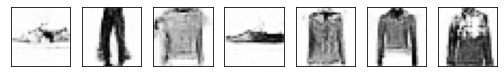

118/118 [==============================] - 68s 576ms/step - d_loss: -1.8752 - g_loss: 5.1024
Epoch 47/100
118/118 [==============================] - ETA: 0s - d_loss: -1.9036 - g_loss: 5.9037epoch 46


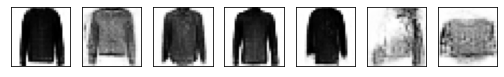

118/118 [==============================] - 68s 577ms/step - d_loss: -1.9094 - g_loss: 5.8779
Epoch 48/100
118/118 [==============================] - ETA: 0s - d_loss: -1.7875 - g_loss: 3.8974epoch 47


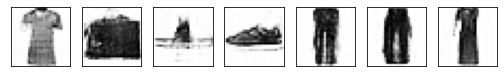

118/118 [==============================] - 68s 576ms/step - d_loss: -1.7840 - g_loss: 3.9020
Epoch 49/100
118/118 [==============================] - ETA: 0s - d_loss: -1.8677 - g_loss: 3.9776epoch 48


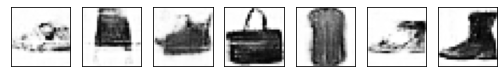

118/118 [==============================] - 68s 576ms/step - d_loss: -1.8629 - g_loss: 3.9957
Epoch 50/100
118/118 [==============================] - ETA: 0s - d_loss: -1.8062 - g_loss: 4.9424epoch 49


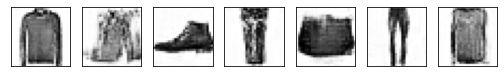

118/118 [==============================] - 68s 576ms/step - d_loss: -1.8102 - g_loss: 4.9772
Epoch 51/100
118/118 [==============================] - ETA: 0s - d_loss: -1.8130 - g_loss: 4.3546epoch 50


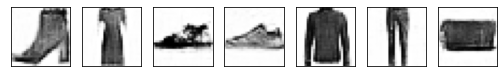

118/118 [==============================] - 68s 576ms/step - d_loss: -1.8123 - g_loss: 4.3536
Epoch 52/100
118/118 [==============================] - ETA: 0s - d_loss: -1.7422 - g_loss: 5.0324epoch 51


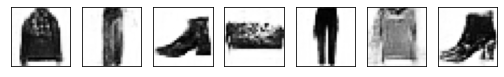

118/118 [==============================] - 68s 580ms/step - d_loss: -1.7431 - g_loss: 5.0206
Epoch 53/100
118/118 [==============================] - ETA: 0s - d_loss: -1.6844 - g_loss: 3.1830epoch 52


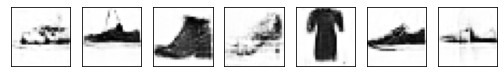

118/118 [==============================] - 68s 576ms/step - d_loss: -1.6876 - g_loss: 3.1826
Epoch 54/100
118/118 [==============================] - ETA: 0s - d_loss: -1.8066 - g_loss: 4.0000epoch 53


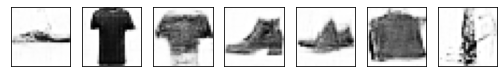

118/118 [==============================] - 68s 576ms/step - d_loss: -1.8055 - g_loss: 3.9917
Epoch 55/100
118/118 [==============================] - ETA: 0s - d_loss: -1.7048 - g_loss: 3.8307epoch 54


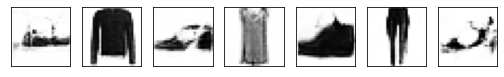

118/118 [==============================] - 68s 576ms/step - d_loss: -1.6935 - g_loss: 3.8257
Epoch 56/100
118/118 [==============================] - ETA: 0s - d_loss: -1.6707 - g_loss: 3.3037epoch 55


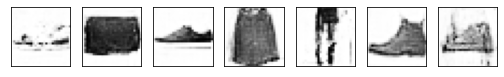

118/118 [==============================] - 68s 575ms/step - d_loss: -1.6906 - g_loss: 3.2951
Epoch 57/100
118/118 [==============================] - ETA: 0s - d_loss: -1.6422 - g_loss: 2.8035epoch 56


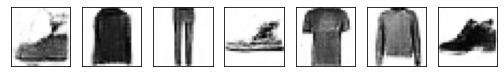

118/118 [==============================] - 68s 575ms/step - d_loss: -1.6553 - g_loss: 2.8000
Epoch 58/100
118/118 [==============================] - ETA: 0s - d_loss: -1.7662 - g_loss: 4.4345epoch 57


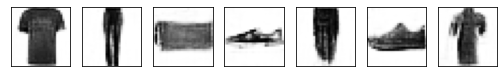

118/118 [==============================] - 68s 576ms/step - d_loss: -1.7553 - g_loss: 4.4381
Epoch 59/100
118/118 [==============================] - ETA: 0s - d_loss: -1.6781 - g_loss: 2.7133epoch 58


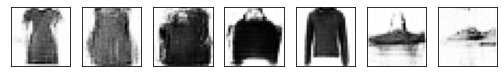

118/118 [==============================] - 68s 578ms/step - d_loss: -1.6858 - g_loss: 2.7102
Epoch 60/100
118/118 [==============================] - ETA: 0s - d_loss: -1.6403 - g_loss: 3.1627epoch 59


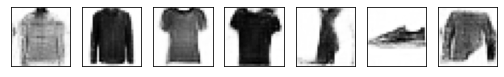

118/118 [==============================] - 68s 576ms/step - d_loss: -1.6325 - g_loss: 3.1573
Epoch 61/100
118/118 [==============================] - ETA: 0s - d_loss: -1.6392 - g_loss: 3.1534epoch 60


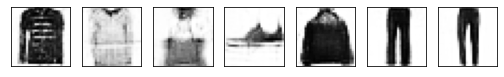

118/118 [==============================] - 68s 576ms/step - d_loss: -1.6411 - g_loss: 3.1264
Epoch 62/100
118/118 [==============================] - ETA: 0s - d_loss: -1.6490 - g_loss: 3.5013epoch 61


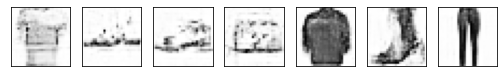

118/118 [==============================] - 68s 576ms/step - d_loss: -1.6401 - g_loss: 3.4939
Epoch 63/100
118/118 [==============================] - ETA: 0s - d_loss: -1.5484 - g_loss: 5.1490epoch 62


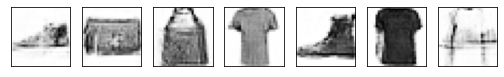

118/118 [==============================] - 68s 576ms/step - d_loss: -1.5402 - g_loss: 5.1392
Epoch 64/100
118/118 [==============================] - ETA: 0s - d_loss: -1.6880 - g_loss: 3.7876epoch 63


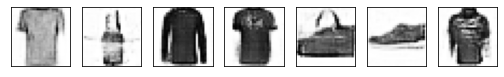

118/118 [==============================] - 68s 576ms/step - d_loss: -1.6971 - g_loss: 3.7696
Epoch 65/100
118/118 [==============================] - ETA: 0s - d_loss: -1.5518 - g_loss: 3.2614epoch 64


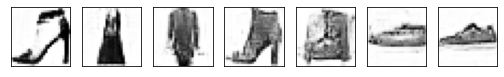

118/118 [==============================] - 68s 576ms/step - d_loss: -1.5462 - g_loss: 3.2583
Epoch 66/100
118/118 [==============================] - ETA: 0s - d_loss: -1.7232 - g_loss: 1.9898epoch 65


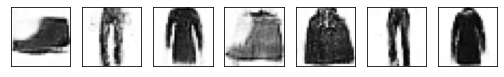

118/118 [==============================] - 68s 576ms/step - d_loss: -1.7210 - g_loss: 1.9922
Epoch 67/100
118/118 [==============================] - ETA: 0s - d_loss: -1.6996 - g_loss: 3.4591epoch 66


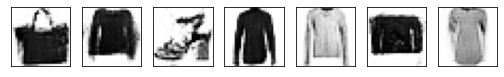

118/118 [==============================] - 68s 577ms/step - d_loss: -1.6946 - g_loss: 3.4177
Epoch 68/100
118/118 [==============================] - ETA: 0s - d_loss: -1.6422 - g_loss: 1.4226epoch 67


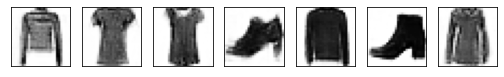

118/118 [==============================] - 68s 576ms/step - d_loss: -1.6583 - g_loss: 1.3873
Epoch 69/100
118/118 [==============================] - ETA: 0s - d_loss: -1.7304 - g_loss: 1.0993epoch 68


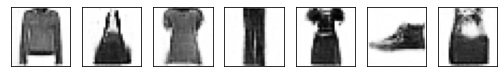

118/118 [==============================] - 68s 576ms/step - d_loss: -1.7326 - g_loss: 1.0650
Epoch 70/100
118/118 [==============================] - ETA: 0s - d_loss: -1.6203 - g_loss: 1.6929epoch 69


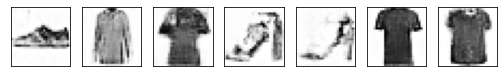

118/118 [==============================] - 68s 576ms/step - d_loss: -1.6399 - g_loss: 1.6899
Epoch 71/100
118/118 [==============================] - ETA: 0s - d_loss: -1.5586 - g_loss: 2.6711epoch 70


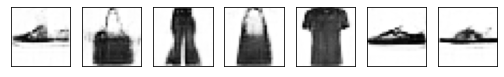

118/118 [==============================] - 68s 576ms/step - d_loss: -1.5515 - g_loss: 2.6604
Epoch 72/100
118/118 [==============================] - ETA: 0s - d_loss: -1.5847 - g_loss: 2.1381epoch 71


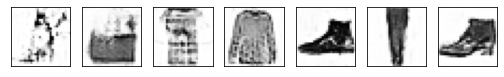

118/118 [==============================] - 68s 576ms/step - d_loss: -1.5762 - g_loss: 2.1633
Epoch 73/100
118/118 [==============================] - ETA: 0s - d_loss: -1.5605 - g_loss: 3.3414epoch 72


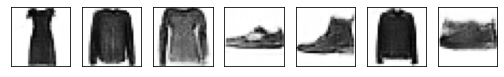

118/118 [==============================] - 68s 576ms/step - d_loss: -1.5698 - g_loss: 3.3483
Epoch 74/100
118/118 [==============================] - ETA: 0s - d_loss: -1.6085 - g_loss: 3.0494epoch 73


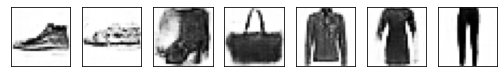

118/118 [==============================] - 68s 577ms/step - d_loss: -1.6109 - g_loss: 3.0310
Epoch 75/100
118/118 [==============================] - ETA: 0s - d_loss: -1.5667 - g_loss: 2.3548epoch 74


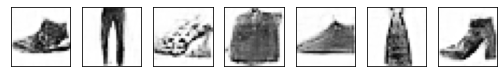

118/118 [==============================] - 68s 576ms/step - d_loss: -1.5543 - g_loss: 2.3663
Epoch 76/100
118/118 [==============================] - ETA: 0s - d_loss: -1.5585 - g_loss: 3.5245epoch 75


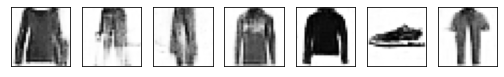

118/118 [==============================] - 68s 576ms/step - d_loss: -1.5694 - g_loss: 3.5040
Epoch 77/100
118/118 [==============================] - ETA: 0s - d_loss: -1.5031 - g_loss: 2.6157epoch 76


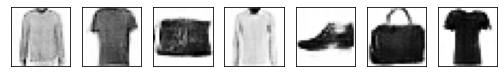

118/118 [==============================] - 68s 576ms/step - d_loss: -1.5063 - g_loss: 2.5922
Epoch 78/100
118/118 [==============================] - ETA: 0s - d_loss: -1.5378 - g_loss: 2.5411epoch 77


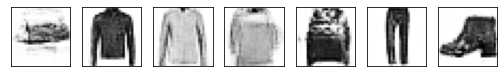

118/118 [==============================] - 68s 576ms/step - d_loss: -1.5445 - g_loss: 2.5533
Epoch 79/100
118/118 [==============================] - ETA: 0s - d_loss: -1.5387 - g_loss: 1.3878epoch 78


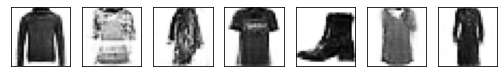

118/118 [==============================] - 68s 576ms/step - d_loss: -1.5350 - g_loss: 1.3710
Epoch 80/100
118/118 [==============================] - ETA: 0s - d_loss: -1.5251 - g_loss: 3.5544epoch 79


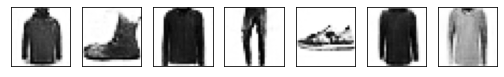

118/118 [==============================] - 68s 576ms/step - d_loss: -1.5016 - g_loss: 3.5518
Epoch 81/100
118/118 [==============================] - ETA: 0s - d_loss: -1.5167 - g_loss: 4.3415epoch 80


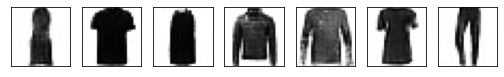

118/118 [==============================] - 68s 576ms/step - d_loss: -1.5182 - g_loss: 4.4002
Epoch 82/100
118/118 [==============================] - ETA: 0s - d_loss: -1.5026 - g_loss: 3.9304epoch 81


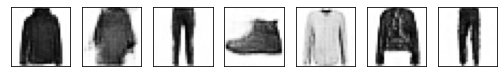

118/118 [==============================] - 68s 578ms/step - d_loss: -1.5068 - g_loss: 3.9238
Epoch 83/100
118/118 [==============================] - ETA: 0s - d_loss: -1.4717 - g_loss: 4.2351epoch 82


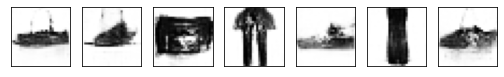

118/118 [==============================] - 68s 576ms/step - d_loss: -1.4680 - g_loss: 4.2255
Epoch 84/100
118/118 [==============================] - ETA: 0s - d_loss: -1.4831 - g_loss: 2.0010epoch 83


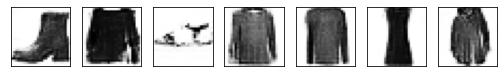

118/118 [==============================] - 68s 576ms/step - d_loss: -1.4991 - g_loss: 1.9747
Epoch 85/100
118/118 [==============================] - ETA: 0s - d_loss: -1.5765 - g_loss: 1.0656epoch 84


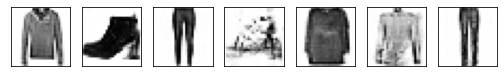

118/118 [==============================] - 68s 576ms/step - d_loss: -1.5811 - g_loss: 1.0603
Epoch 86/100
118/118 [==============================] - ETA: 0s - d_loss: -1.4980 - g_loss: 1.2794epoch 85


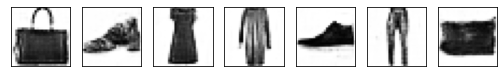

118/118 [==============================] - 68s 576ms/step - d_loss: -1.4913 - g_loss: 1.2821
Epoch 87/100
118/118 [==============================] - ETA: 0s - d_loss: -1.5533 - g_loss: 2.8963epoch 86


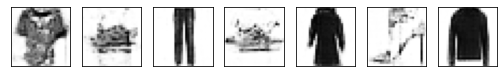

118/118 [==============================] - 68s 576ms/step - d_loss: -1.5620 - g_loss: 2.8439
Epoch 88/100
118/118 [==============================] - ETA: 0s - d_loss: -1.5006 - g_loss: 2.4088epoch 87


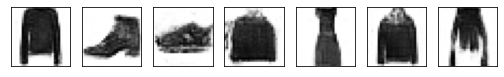

118/118 [==============================] - 68s 576ms/step - d_loss: -1.4759 - g_loss: 2.4063
Epoch 89/100
118/118 [==============================] - ETA: 0s - d_loss: -1.4752 - g_loss: 2.7545epoch 88


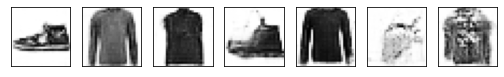

118/118 [==============================] - 68s 578ms/step - d_loss: -1.4484 - g_loss: 2.7484
Epoch 90/100
118/118 [==============================] - ETA: 0s - d_loss: -1.3640 - g_loss: 1.7295epoch 89


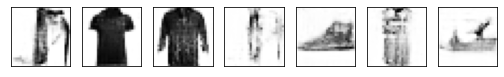

118/118 [==============================] - 68s 576ms/step - d_loss: -1.3616 - g_loss: 1.7176
Epoch 91/100
118/118 [==============================] - ETA: 0s - d_loss: -1.5161 - g_loss: 2.4652epoch 90


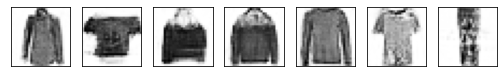

118/118 [==============================] - 68s 576ms/step - d_loss: -1.5198 - g_loss: 2.4781
Epoch 92/100
118/118 [==============================] - ETA: 0s - d_loss: -1.4635 - g_loss: 3.2234epoch 91


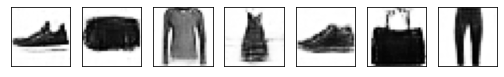

118/118 [==============================] - 68s 576ms/step - d_loss: -1.4610 - g_loss: 3.2180
Epoch 93/100
118/118 [==============================] - ETA: 0s - d_loss: -1.4974 - g_loss: 0.6945epoch 92


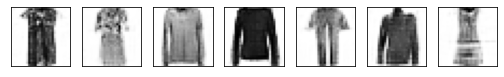

118/118 [==============================] - 68s 576ms/step - d_loss: -1.5080 - g_loss: 0.7017
Epoch 94/100
118/118 [==============================] - ETA: 0s - d_loss: -1.4654 - g_loss: 1.6059epoch 93


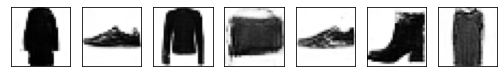

118/118 [==============================] - 68s 576ms/step - d_loss: -1.4623 - g_loss: 1.6133
Epoch 95/100
118/118 [==============================] - ETA: 0s - d_loss: -1.4369 - g_loss: 3.0939epoch 94


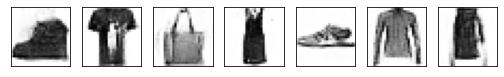

118/118 [==============================] - 68s 575ms/step - d_loss: -1.4326 - g_loss: 3.0848
Epoch 96/100
118/118 [==============================] - ETA: 0s - d_loss: -1.5120 - g_loss: 1.4071epoch 95


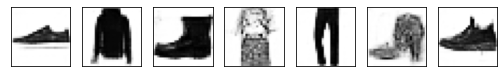

118/118 [==============================] - 68s 576ms/step - d_loss: -1.5253 - g_loss: 1.3866
Epoch 97/100
118/118 [==============================] - ETA: 0s - d_loss: -1.5747 - g_loss: 1.3328epoch 96


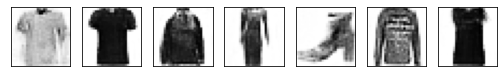

118/118 [==============================] - 68s 577ms/step - d_loss: -1.6121 - g_loss: 1.3554
Epoch 98/100
118/118 [==============================] - ETA: 0s - d_loss: -1.3824 - g_loss: 1.8669epoch 97


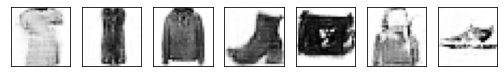

118/118 [==============================] - 68s 576ms/step - d_loss: -1.3988 - g_loss: 1.8955
Epoch 99/100
118/118 [==============================] - ETA: 0s - d_loss: -1.4705 - g_loss: 1.8823epoch 98


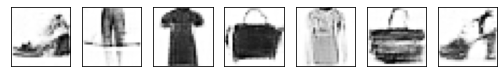

118/118 [==============================] - 68s 576ms/step - d_loss: -1.4560 - g_loss: 1.8890
Epoch 100/100
118/118 [==============================] - ETA: 0s - d_loss: -1.4071 - g_loss: 1.3933epoch 99


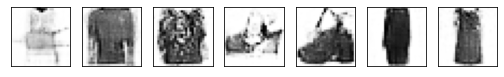

118/118 [==============================] - 68s 576ms/step - d_loss: -1.4004 - g_loss: 1.3724


In [7]:
generator_optimizer = Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)
discriminator_optimizer = Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)

def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss # fake는 작을 수록, real는 클 수록 좋다.

def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)

wgan = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=noise_dim,
    discriminator_extra_steps=3,
)

wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)

cbk = GANMonitor(num_img=8, latent_dim=noise_dim)
wgan.fit(train_images, batch_size=BATCH_SIZE, epochs=100, callbacks=[cbk])

Display the last generated images:


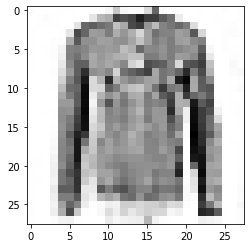

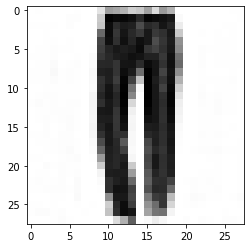

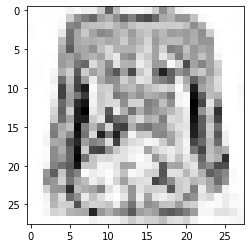

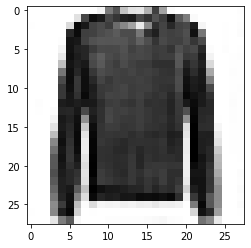

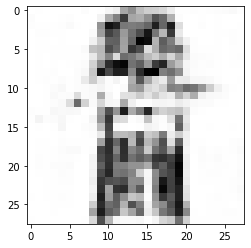

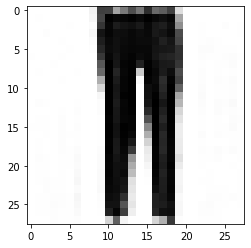

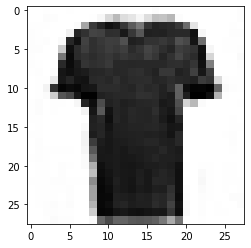

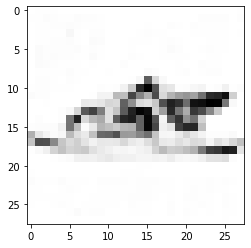

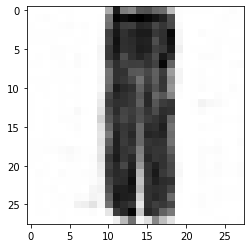

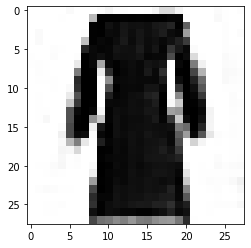

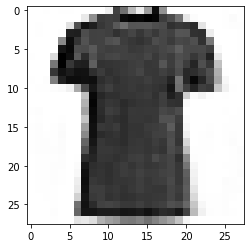

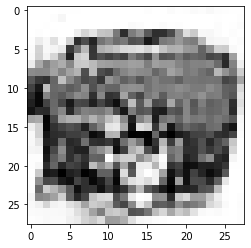

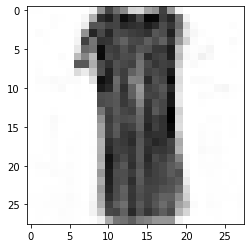

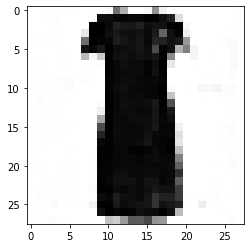

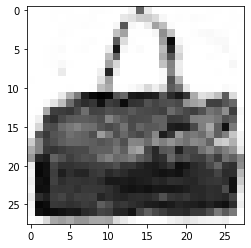

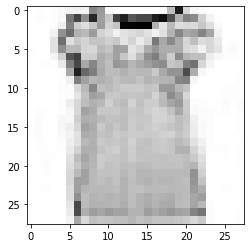

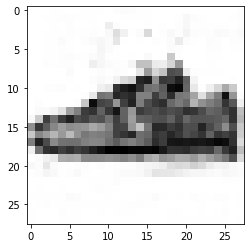

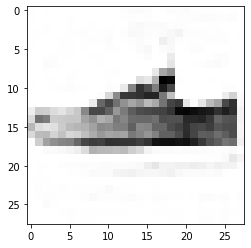

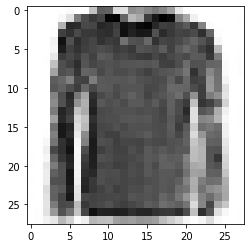

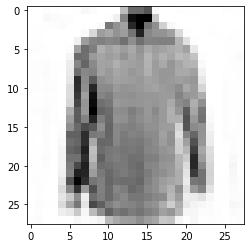

In [8]:
import matplotlib.pyplot as plt

random_latent_vectors = tf.random.normal(shape=(20, noise_dim))

generated_images = wgan.generator(random_latent_vectors)
generated_images = (generated_images * 127.5) + 127.5
for image in generated_images:
  plt.imshow(image.numpy().squeeze(), cmap="binary")
  plt.show()